In [15]:
# dense_layer
import numpy as np
from nnfs.datasets import spiral_data

class LayerDense:
    # layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights with small random numbers
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        
        # Initialize biases with zeros
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember inputs for potential backpropagation     
        self.inputs = inputs

        #Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases   

    # Backward pass
    def backward(self, dvalues):
        # Gradient on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)



In [16]:
# Relu activation
class ActivationReLU:
    # Forward pass
    def forward(self, inputs):
        # remember inputs
        self.inputs = inputs
        # calculate output values from inputs
        self.output = np.maximum(0, inputs)
    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0    



In [17]:
# create softmax activation
class ActivationSoftmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

In [18]:
# cross-entropy loss
# Lecture 8 - Coding the cross entropy loss in Python (from scratch)
class Loss_CategoricalCrossentropy:
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = y_pred.shape[0]
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        # Probabilities for target values
        # Only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    # Lecrure 18 - Implementing backpropagation on the cross entropy loss function
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues) # all one dimensional values in 2 dimensional array
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0]) # lenght of first sample
        
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [19]:
#Softmax classifier - combined Softmax activation and cross-entropy loss
class ActivationSoftmax_LossCategoricalCrossentropy():
    #create activation and loss function objects
    def __init__(self):
        self.activation = ActivationSoftmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        self.loss = Loss_CategoricalCrossentropy()
        return self.loss.forward(self.output, y_true)
    
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        
        # If labels are one-hot encoded, turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()

        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1 # Lecture 19 - Combined backpropagation on softmax activation and cross entropy loss
        # Normalize gradient
        self.dinputs = self.dinputs / samples

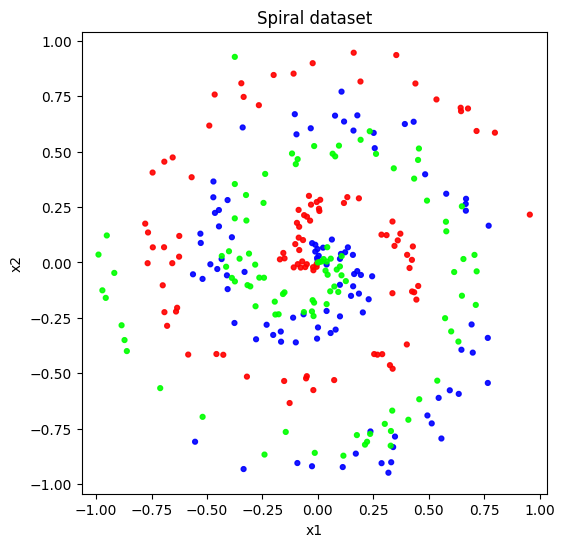

In [20]:
# create dataset
X, y = spiral_data(samples=100, classes=3)
# plot dataset
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', s=12, alpha=0.9)
plt.title('Spiral dataset')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.show()

In [21]:
# create dataset
X, y = spiral_data(samples=100, classes=3)
# create dense layer with 2 input features and 3 output values
dense1 = LayerDense(2, 3)
# create ReLU activation (to be used with dense layer)
activation1 = ActivationReLU()
# create second dense layer with 3 input features and 3 output values
dense2 = LayerDense(3, 3)
# crate softmax classifier's combined loss and activation
loss_activation = ActivationSoftmax_LossCategoricalCrossentropy()
# forward pass through first dense layer
dense1.forward(X)
# forward pass through ReLU activation
activation1.forward(dense1.output)
# forward pass through second dense layer
dense2.forward(activation1.output)
# forward pass through softmax activation and loss function
loss = loss_activation.forward(dense2.output, y)

print(loss_activation.output[:5]) # show output of the first 5 samples

#print('losd',loss)

#calculate accuracy
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)
print('accuracy:', accuracy)   

# backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)
# print gradients
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)



[[0.33333333 0.33333333 0.33333333]
 [0.33333337 0.33333312 0.33333351]
 [0.3333331  0.33333338 0.33333352]
 [0.33333318 0.33333306 0.33333376]
 [0.33333338 0.33333261 0.33333401]]
accuracy: 0.35
[[ 4.04045542e-05 -8.12120517e-06  2.60880579e-05]
 [-3.45000555e-05  2.54268722e-04  6.60392668e-05]]
[[8.84992825e-05 5.85932707e-04 8.58762316e-05]]
[[-9.18467142e-07 -3.27726887e-05  3.36911558e-05]
 [ 1.02337448e-04 -1.49561961e-04  4.72245127e-05]
 [ 4.49094059e-05 -4.31305022e-06 -4.05963557e-05]]
[[ 1.00668680e-06 -4.98945707e-06  3.98277027e-06]]


In [22]:
# Gradient descent optimizer
class OptimizerSGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate

    # Update parameters
    def update_params(self, layer):
        # Vanilla SGD parameter update
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases 

In [29]:
#create dataset
X, y = spiral_data(samples=100, classes=3)
# create dense layer with 2 input features and 3 output values
dense1 = LayerDense(2, 64)
# create ReLU activation (to be used with dense layer)
activation1 = ActivationReLU()
# create second dense layer with 64 input features and 3 output values
dense2 = LayerDense(64, 3)
# crate softmax classifier's combined loss and activation
loss_activation = ActivationSoftmax_LossCategoricalCrossentropy()
# create optimizer
optimizer = OptimizerSGD(learning_rate=1.0)

# Train in loop
for epoch in range(10001):
    # Forward pass through first dense layer
    dense1.forward(X)
    # Forward pass through ReLU activation
    activation1.forward(dense1.output)
    # Forward pass through second dense layer
    dense2.forward(activation1.output)
    # Forward pass through softmax activation and loss function
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, ' +
              f'loss: {np.mean(loss):.3f}, ' +
              f'accuracy: {accuracy:.3f}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

Epoch: 0, loss: 1.099, accuracy: 0.333
Epoch: 100, loss: 1.077, accuracy: 0.413
Epoch: 200, loss: 1.067, accuracy: 0.427
Epoch: 300, loss: 1.066, accuracy: 0.410
Epoch: 400, loss: 1.065, accuracy: 0.407
Epoch: 500, loss: 1.065, accuracy: 0.420
Epoch: 600, loss: 1.064, accuracy: 0.417
Epoch: 700, loss: 1.063, accuracy: 0.427
Epoch: 800, loss: 1.061, accuracy: 0.430
Epoch: 900, loss: 1.058, accuracy: 0.447
Epoch: 1000, loss: 1.056, accuracy: 0.440
Epoch: 1100, loss: 1.052, accuracy: 0.457
Epoch: 1200, loss: 1.049, accuracy: 0.457
Epoch: 1300, loss: 1.044, accuracy: 0.460
Epoch: 1400, loss: 1.038, accuracy: 0.473
Epoch: 1500, loss: 1.040, accuracy: 0.477
Epoch: 1600, loss: 1.034, accuracy: 0.427
Epoch: 1700, loss: 1.042, accuracy: 0.433
Epoch: 1800, loss: 1.031, accuracy: 0.403
Epoch: 1900, loss: 1.022, accuracy: 0.467
Epoch: 2000, loss: 1.039, accuracy: 0.413
Epoch: 2100, loss: 1.015, accuracy: 0.413
Epoch: 2200, loss: 1.018, accuracy: 0.473
Epoch: 2300, loss: 1.012, accuracy: 0.450
Epoc